# Sharpening thermodynamic vertical profiles of reanalysis data

### This code is developed by Ehsan Erfani. The scientific methods are outlined by scientists @ UW ATMOS. The saturation adjustment function is based on Peter Blossey's Matlab calculations. 

In [1]:
import numpy as np # linear algebra
import os
import matplotlib
matplotlib.use('Agg')
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from pandas import Series, DataFrame
from netCDF4 import Dataset
from math import log10
from scipy import interpolate
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from scipy.optimize import fsolve
from scipy.optimize import fmin
import warnings
warnings.filterwarnings("ignore")
from scipy.optimize import minimize
import math

In [2]:
#### Parameters:

# region:
region   = '04'

# initial time of trajectory:
yyyy = 2019
mm   = 8
dd   = 14 
HH   = 9 

# Hour that will be used for sharpening:
HH_adj = 9

casename  = 'reg' + region + '_' + str(yyyy) + f"{mm:02n}" + f"{dd:02n}"

traj_dirc = ['forward'] # trajectory direction, options: ['forward'], or  ['forward', 'backward']

ylim      = 3000  # upper limit for plotting vertical profiles

## Functions

In [3]:
### Functions to read a variable from forward and backward files and concatenate them
def read_var_1D(var_name):
    if traj_dirc == ['forward', 'backward']:
        var = np.concatenate( ( Traj_datab.variables[var_name][(-HH + 1):], \
                              Traj_data.variables[var_name][:]), axis=0)
    else:
        var = Traj_data.variables[var_name][:]
    return var

def read_var_2D(var_name):
    if traj_dirc == ['forward', 'backward']:
        var = np.concatenate( ( Traj_datab.variables[var_name][(-HH + 1):,:], \
                              Traj_data.variables[var_name][:]), axis=0)
    else:
        var = Traj_data.variables[var_name][:]
    return var


########
# interpolate from ERA5 coarse vertical grid to fine grid:
def interp_to_forc_Z(ERA_p2, ERA_var, p_interp):
    f = interpolate.interp1d(ERA_p2, ERA_var, fill_value="extrapolate")
    output = f(np.array(p_interp))
    return output


########
### Calculate inversion height (min of dtheta/dz * dRH/dz)
def inv_h(THETA, RH, dzz, zz):        
#    d_THETA = delta(THETA)
#    d_RH = delta(RH)
    d_THETA  = THETA[:-1] - THETA[1:]
    d_RH     = RH[:-1] - RH[1:]
    z        = zz[i,:]  if len(zz.shape) > 1 else zz
    dz       = dzz[i,:] if len(zz.shape) > 1 else dzz
    dTHETA_dz= d_THETA / dz[1:]
    dRH_dz   = d_RH / dz[1:]
    dTHETA_dz[dTHETA_dz < 0] = 0
    dRH_dz[dRH_dz > 0] = 0    
    func     = dTHETA_dz * dRH_dz
    indx     = np.min(np.where(func == np.nanmin(func))[0])                    
    # approximate func as a parabola around the minimum and find the height where that parabola is minimized. 
    # This will allow the inversion height to vary continuously as the input profiles change.
    # inversion_test is defined at midpoints of grid
    zavg     = 0.5 * (z[:-1] + z[1:])
    rnge     = range(indx-1, indx+2)
    # we define the parabola, converting from m to km.
    pp       = np.polyfit(1e-3 * zavg[rnge], func[rnge], 2)
    # take the derivative of the parabola in coeffient space.
    pp_prime = np.array([2 * pp[0], pp[1]]) # this is its derivative
    # find the zero-crossing of the derivative. This is the inversion height in meters
    z_inv    = -1e3 * pp_prime[1] / pp_prime[0]         
    return z_inv


########
# Function to calculate saturation mixing ratio from es and P, and es from T based on Bulk equation
# inputs: P in hPa, and Tk in K.
def sat_q(Tk, P):
    #Tc    = Tk - 273.15 
    Tc    = max(-85, min(Tk - 273.15, 70))
    #es    = 6.1121 * np.exp( (18.678 - Tc / 234.5) * (Tc / (257.14 + Tc)) ) # Bulk Eq.
    pcoef_esw = [-0.3704404e-15,   0.2564861e-13,   0.6936113e-10, \
              0.2031998e-7,    0.2995057e-5,    0.2641412e-3,  \
              0.1430341e-1,    0.4440316,       6.105851]
    es = np.polyval(pcoef_esw, Tc)
#    qsat = 621.97 * es / (P - es)
    qsat = 621.97 * es / max( es, (P - es) )

    return abs(qsat)
#qsat = sat_q(ERA_t, ERA_p)


#######
# Function to compute the temperature of moist air that is induced by the condensation/evaporation of liquid water
# (NO ICE PERMITTED), resulting in a mixture that is at equilibrium. 
# The equilibrium mixture will either have no liquid water or its water vapor mixing ratio will be equal to the saturation value.
def sat_adj(Z, TL, QT, P):
    QV    = QT.copy()
    QL    = QT.copy()
    T0    = QT.copy()
    T     = QT.copy()
    QV[:] = np.nan
    QL[:] = np.nan
    T0[:] = np.nan
    T[:]  = np.nan
    for i in range(QT.shape[0]):
        T0[i]  = TL[i] - g * Z[i] / Cp# + (Lv / Cp) * QT[i] / 1000
        qsat = sat_q(T0[i], P[i])
        if qsat >= QT[i]:
            QV[i] = QT[i]
            QL[i] = 0
            T[i]  = T0[i]
        #elif qsat < QT[i]:
        else:
            T0[i]  = TL[i] - g * Z[i] / Cp + (Lv / Cp) * QT[i] / 1000
            # Solve for T, based on the notion that moist static energy is unchanged by condensation/evaporation: 
            # Build a function that takes in a guess for T along with fixed values of TL, QT, and Z. 
            # Search for a value of T that returns f(T) as 0. 
            # This basically says that our guess for T should give the same moist static energy as that implied by 
            # the input profiles TL(z) and QT(z).
            f = lambda x: x + g * Z[i] / Cp + (Lv / Cp) * min( QT[i], sat_q(x, P[i]) ) / 1000 - TL[i] - (Lv / Cp) * QT[i] / 1000
            T[i] = fsolve(f, T0[i])
            QV[i] = sat_q(T[i], P[i])
            QL[i] = QT[i] - QV[i]

    return QL, T


########
## find delta after calculating mid-point values
def delta(THETA):
    THETA = THETA[::-1]
    nz = THETA.shape[0]
    THETAi = np.concatenate((THETA, np.array([0.])))
    THETAi[:] = np.nan    
    THETAi[0] = 0
    THETAi[1:nz] = 0.5 * (THETA[:nz-1] + THETA[1:nz])
    THETAi[nz] = 1.5 * THETA[nz-1] - 0.5 * THETA[nz-2]
    d_THETA = THETAi[1:] - THETAi[:-1]    
    return d_THETA[::-1]

# Function to calculate rho-weighted vertical integral
def z_integral(var, ERA_z, ERA_RHO, upbound):
    idx = np.nanmin(np.where( abs(ERA_z - upbound) == np.nanmin(abs(ERA_z - upbound)) ))
    delta_ERA_z = delta(ERA_z)
    var_integ = np.nansum(var[idx:] * delta_ERA_z[idx:] * ERA_RHO[idx:])
    return var_integ


###########
## Function to produce modified initial ERA5 profile
def produce_ERA5_profile(ERA_Z, ERA_TL, ERA_QT, CTH, TL_ML, QT_ML, L_FT, TL_diff, QT_diff):
    Zi = CTH
    idx_zi    = np.nanmax( np.where( abs(ERA_Z - Zi) == np.nanmin(abs(ERA_Z - Zi)) ) )
    # Divide variables in two parts: FT and BL
    ERA_Z_BL  = ERA_Z[idx_zi:]
    ERA_Z_FT  = ERA_Z[:idx_zi]
    ERA_TL_BL = ERA_TL[idx_zi:]
    ERA_TL_FT = ERA_TL[:idx_zi]
    ERA_QT_BL = ERA_QT[idx_zi:]
    ERA_QT_FT = ERA_QT[:idx_zi]
    
    # Define outputs:
    TL_BL_o = ERA_TL_BL.copy()
    TL_FT_o = ERA_TL_FT.copy()
    QT_BL_o = ERA_QT_BL.copy()
    QT_FT_o = ERA_QT_FT.copy()

    TL_BL_o[:] = np.nan
    TL_FT_o[:] = np.nan
    QT_BL_o[:] = np.nan
    QT_FT_o[:] = np.nan
    
    ## FT:
    idx_L_FT    = np.nanmax( np.where( abs(ERA_Z_FT - (Zi + L_FT) ) == np.nanmin(abs(ERA_Z_FT - (Zi + L_FT) )) ) )
    TL_FT_o[:idx_L_FT+1] = ERA_TL_FT[:idx_L_FT+1]
    QT_FT_o[:idx_L_FT+1] = ERA_QT_FT[:idx_L_FT+1]
    
    # fit a line to the ERA TL & QT profiles away from the inversion, and extrapolate down to the inversion. 
    zind  = np.where( (ERA_Z_FT >= (Zi + L_FT) ) & (ERA_Z_FT <= (Zi + f_FT * L_FT)) )[0]
    zind2 = np.where( (ERA_Z_FT >=  Zi )         & (ERA_Z_FT <= (Zi + L_FT)) )[0]
    # Include a few points above the zi+L_FT to avoid jump in the FT profiles.
    zind2 = np.concatenate( (np.array([np.nanmin(zind2) - 4, np.nanmin(zind2) - 3, np.nanmin(zind2) - 2,\
                                   np.nanmin(zind2) - 1]), zind2) )      
    TL_FT_o[zind2] = np.polyval(np.polyfit(ERA_Z_FT[zind], ERA_TL_FT[zind], 1), ERA_Z_FT[zind2])
    QT_FT_o[zind2] = np.polyval(np.polyfit(ERA_Z_FT[zind], ERA_QT_FT[zind], 1), ERA_Z_FT[zind2])
    
    TL_FT_o = np.array([max(TL_FT_o[i], TL_ML + abs(TL_diff)) for i in range(len(TL_FT_o))])
    QT_FT_o = np.array([min(QT_FT_o[i], QT_ML - abs(QT_diff)) for i in range(len(QT_FT_o))])
#    QT_FT_o = np.array([min(QT_FT_o[i], ERA_QT_FT[i]) for i in range(len(QT_FT_o))])

    # Make sure that dq/dz <= 0 at height < zi + L_FT:
    for i in range(len(QT_FT_o) -1):
        if QT_FT_o[i+1] < QT_FT_o[i] and i > idx_L_FT - 12:
            QT_FT_o[i+1] = QT_FT_o[i]

#     QT_FT_o = QT_FT_o[::-1]
#     for i in range(len(QT_FT_o) -1):
#         if QT_FT_o[i+1] > QT_FT_o[i] and i > idx_L_FT+1:
#             QT_FT_o[i+1] = QT_FT_o[i]
#     QT_FT_o = QT_FT_o[::-1]

    
    ## BL:
    TL_BL_o = np.array([min(ERA_TL_BL[i], TL_ML) for i in range(len(ERA_TL_BL))])
    QT_BL_o = np.array([max(ERA_QT_BL[i], QT_ML) for i in range(len(ERA_QT_BL))])
    
    ## Concatenate BL and FT
    TL_o = np.concatenate((TL_FT_o, TL_BL_o))
    QT_o = np.concatenate((QT_FT_o, QT_BL_o))
    
    return TL_o, QT_o


############
# function to calculate the parameter than will be minimzed later
def optimize_ERA5(ERA_Z, ERA_TL, ERA_QT, LWP_target, CTH_target, CTH, TL_ML, QT_ML, ff, TL_diff, QT_diff):
    TL_o, QT_o = produce_ERA5_profile(ERA_Z, ERA_TL, ERA_QT, CTH, TL_ML, QT_ML,L_FT, TL_diff, QT_diff)    
    
    # compute LWC and Tadj by using saturation adjustment at each height
    QL_o_adj, T_o_adj = sat_adj(ERA_Z, TL_o, QT_o, ERA_p)

    # Calculate Trho, which is the density temperature. It's the same as the virtual temperature except for the inclusion of 
    # the density change due to liquid water loading. This will keep the vertically-integrated density from drifting too far 
    # from that of ERA5, which is a more physical constraint than the one on Tl.
    #T_o_adj  = TL_o - g * ERA_Z / Cp + (Lv / Cp) * QL_o_adj / 1000
    T_o_rho    = T_o_adj * (1 + 0.61 * (QT_o - QL_o_adj) / 1000 - QL_o_adj / 1000)
    ERA_T_rho  = ERA_t   * (1 + 0.61 * ERA_q / 1000 - ERA_lwc / 1000)

    # Compute the LWP of the modified profiles and other vertical integrals
    LWP_adj       = z_integral(QL_o_adj, ERA_Z, ERA_RHO, upbound)
    TWP_o         = z_integral(QT_o,     ERA_Z, ERA_RHO, upbound)
    TWP_ERA       = z_integral(ERA_QT,   ERA_Z, ERA_RHO, upbound)
    TL_o_zint     = z_integral(TL_o,     ERA_Z, ERA_RHO, upbound)
    TL_ERA_zint   = z_integral(ERA_TL,   ERA_Z, ERA_RHO, upbound)
    To_rho_zint   = z_integral(T_o_rho,  ERA_Z, ERA_RHO, upbound)
    T_rho_ERA_zint= z_integral(ERA_T_rho,  ERA_Z, ERA_RHO, upbound)    
    ones          = ERA_Z.copy()
    ones[:]       = 1
    RHO_zint      = z_integral(ones,   ERA_Z, ERA_RHO, upbound)
            
    # Output a (positive) number that tells how well the resulting profile matches LWP_target 
    # we have a few targets that we want to match: LWP_adj, vertically-integrated TL_o(z), vertically-integrated QT_o(z) & CTH 
    
    # First, factors; which have a general formula of [1 / (variable uncertainty) ] ^ 2
    # uncertainties are small values for the deviation of the integrated variables 
    # (with each scaled by int_z rho*dz and then squared) 
    # This would essentially force the vertical integrals to be conserved in the new profiles.
    
    # For fac2, using the factor of Lv/Cp forces some equivalence between moisture and temperature errors.  
    # The default ff value is equal to 0.3 kg/m2 because it's probably a couple percent of the TWP.
    # Modifying it has minimal effect on the solution.  
    fac1 = 1 / ( 10.  ** 2 )
#    fac1 = 1e-4 / ( 10.  ** 2 )
    fac2 = (1 / ( ff ** 2 ) ) * ( Cp / Lv ) ** 2 # / 10000
    fac3 = 1 / ( (ff * 1000) ** 2 )
    fac4 = 1 / ( 20.  ** 2 )

    output = fac1 * (LWP_target - LWP_adj) ** 2 + fac2 * (To_rho_zint - T_rho_ERA_zint) ** 2 + \
             fac3 * (TWP_o      - TWP_ERA) ** 2 + fac4 * (CTH_target - CTH) ** 2
    #+ fac2 * (TL_o_zint - TL_ERA_zint) ** 2 + \
    
    return output


########
# Final function to utilize all the other functions in order to modify the ERA5 profiles and calculate the minimization.
# This is done based on the constant ERA5 profiles, initial values of Tl and qt at Zi, and target values of LWP and CTH
# This function also plots the initial and sharpened profiles of qt and Tl
def run_and_plot():
    func_ERA = lambda x: optimize_ERA5(ERA_z, ERA_Tl, ERA_qt, target_lwp, CTH_target, x[0], x[1], x[2], x[3], x[4], x[5])
    res = minimize(func_ERA, (CTH0, TL_ML0, QT_ML0, ff0, TL_diff, QT_diff), method='SLSQP', bounds=bnds)     
    opt_vals = res.x

    TL_o_f2, QT_o_f2 = produce_ERA5_profile(ERA_z, ERA_Tl, ERA_qt, opt_vals[0], opt_vals[1], opt_vals[2], L_FT, opt_vals[4], opt_vals[5])    
    
    QL_o_f, T_o_f = sat_adj(ERA_z, TL_o_f2, QT_o_f2, ERA_p)
    LWP_0  = z_integral(ERA_lwc, ERA_z, ERA_RHO, 10000)
    LWP_f  = z_integral(QL_o_f, ERA_z, ERA_RHO, 10000)
        

    str_CTH0  = '{:.0f}'.format(CTH0)
    str_TL_ML0 = '{:.1f}'.format(TL_ML0)
    str_QT_ML0 = '{:.2f}'.format(QT_ML0)
    str_LWP_0  = '{:.1f}'.format(LWP_0)

    str_CTHf  = '{:.0f}'.format(opt_vals[0])
    str_TL_MLf = '{:.1f}'.format(opt_vals[1])
    str_QT_MLf = '{:.2f}'.format(opt_vals[2])
    str_LWP_f  = '{:.1f}'.format(LWP_f)

    ### range of the x-axis:
    xx1 = 265 
    xx2 = 311
    
    ii_zinv = np.where( abs(ERA_z - opt_vals[0]) == np.nanmin( abs(ERA_z - opt_vals[0]) ) )[0][0]
    p_zinv  = p_interp[ii_zinv] / 100
    
    ###
    fig  = plt.figure(figsize=(11,8))
    axis = fig.add_subplot(111)
#    cc5  = axis.plot(ERA_Tl, ERA_z, c='k', label='ERA5 ctrl $T_l$', linewidth= 2)
    cc5  = axis.plot(ERA_Tl, p_interp/100, c='k', label='ERA5 ctrl $T_l$', linewidth= 2)
    #cc50 = axis.plot(TL_o_f, Z_o_f, c='tab:red', label='ERA5 adj1 $T_l$', linewidth= 1)
    cc500= axis.plot(TL_o_f2, p_interp/100, '-.', c='tab:blue', label='ERA5 adj $T_l$', linewidth= 2)
    #cc60 = axis.hlines(CTH_f, xx1, xx2, colors='tab:red', linestyles='dashed', linewidth=1, label='ERA5 adj1 $Z_{target}$')
#    cc600= axis.hlines(opt_vals[0], xx1, xx2, colors='tab:cyan', linestyles='solid', linewidth=1, label='ERA5 adj $Z_{f}$')#, *, data=None, **kwargs)[source]
    cc600= axis.hlines(p_zinv, xx1, xx2, colors='tab:cyan', linestyles='solid', linewidth=1, label='ERA5 adj $Z_{f}$')#, *, data=None, **kwargs)[source]
    axis.set_ylabel('Pressure Height (hPa)', fontsize = '18')
    axis.set_xlabel('$T_l$ ($K$)', fontsize = '18', horizontalalignment='right', x=.85)
#    axis.set_title('$Z_0=$'+str_CTH0+', $T_{l_0}$='+str_TL_ML0+', $q_{t_0}$='+str_QT_ML0+', $LWP_0$='+str_LWP_0+'\n'+\
#                   '$Z_f=$'+str_CTHf+', $T_{l_f}$='+str_TL_MLf+', $q_{t_f}$='+str_QT_MLf+', $LWP_f$='+str_LWP_f,\
#                   fontsize = '18', horizontalalignment='right', x=.85)
    axis.set_title('$T_{l_0}$='+str_TL_ML0+', $q_{t_0}$='+str_QT_ML0+', $LWP_0$='+str_LWP_0+'\n'+\
                   '$T_{l_f}$='+str_TL_MLf+', $q_{t_f}$='+str_QT_MLf+', $LWP_f$='+str_LWP_f,\
                   fontsize = '18', horizontalalignment='right', x=.85)
#    axis.set_ylim([0, ylim])
    axis.set_ylim([1020, 750])
    axis.set_xlim([xx1, xx2])
    axis.set_xticks(range(290,311,5))
    axis.legend(fontsize = '16', loc='lower right')
    axis.grid(linestyle=':', axis='y', linewidth=1)
    axis.grid(linestyle=':', axis='x', linewidth=1)
    axis.tick_params(axis='both', which='major', labelsize=14)

    ax = axis.twiny()
#    cc7  = ax.plot(ERA_qt, ERA_z, c='k', label='ERA5 ctrl $q_t$', linewidth= 2)
    cc7  = ax.plot(ERA_qt, p_interp/100, c='k', label='ERA5 ctrl $q_t$', linewidth= 2)
    #cc70 = ax.plot(QT_o_f, Z_o_f, c='tab:red', label='ERA5 adj1 $q_t$', linewidth= 1)
    cc700= ax.plot(QT_o_f2, p_interp/100, '-.', c='tab:blue', label='ERA5 adj $q_t$', linewidth= 2)
    ax.set_xlabel('$q_t$ ($g$ $kg^{-1}$)', fontsize = '18', horizontalalignment='right', x=.3)
    ax.set_xlim([1, 30])
    ax.set_xticks(range(2,18,2))
    ax.legend(fontsize = '16', loc='lower left')
    ax.grid(linestyle=':', axis='x', linewidth=1)
    ax.tick_params(axis='both', which='major', labelsize=14)

    print(res)
    print('Initial values: ', CTH0, TL_ML0, QT_ML0, ff0, TL_diff, QT_diff)
    print('Final values: ', opt_vals)
    
    return TL_o_f2, QT_o_f2, QL_o_f, T_o_f, opt_vals    

[1. Creating forcing file for active simulation](#1.-Creating-forcing-file-for-active-simulation)

[2. Creating forcing file for startup simulation](#2.-Creating-forcing-file-for-startup-simulation)


# 1. Creating forcing file for active simulation

## Define parameters and Read input files

In [4]:
forcing_fname = 'Forcings_NEP_'    + region + '_' + str(yyyy) + f"{mm:02n}" + f"{dd:02n}" + '.nc'
traj_for_fname= 'st_72h_forward_'  + region + '_' + str(yyyy) + f"{mm:02n}" + f"{dd:02n}" + '.nc'
traj_bck_fname= 'st_48h_backward_' + region + '_' + str(yyyy) + f"{mm:02n}" + f"{dd:02n}" + '.nc'
init_time     = str(yyyy) + '-' + f"{mm:02n}" + '-' + f"{dd:02n}" + ' 00Z' 
bdate         = nbdate = int(str(yyyy)[2:] + f"{mm:02n}" + f"{dd:02n}")

subdir        = 'Sharpened'

# constants from SAM's SRC/params.f90
Rd    = 287
Cp    = 1004   # specific heat of dry air at constant pressure: J/kg/K, 1005.7 
Lv    = 2.5e6  # latent heat of vaporization: J/kg
g     = 9.81   # gravitation
Rd_cp = Rd / Cp  # 0.286


## Replace forcing with an original one to avoid any issue in the existing file
os.popen('cp ' + forcing_fname + ' ./' + subdir + '/' ).read()

##### read various files
forcing     = Dataset('./' + subdir + '/' + forcing_fname)

# These are trajectory files:
Traj_data  = Dataset('../Lagrangian_project/' + traj_for_fname)
# Just in case there is a backward trajectory:
# Traj_datab = Dataset('../Lagrangian_project/' + traj_bck_fname)

####
idx_t = 6 # This indicates the hours from start that sharpening will be applied

In [5]:
###### Read various satellite and reanalysis ########
## Only initialization time!

### Time
if traj_dirc == ['forward', 'backward']:
    T_time = np.concatenate( ( (Traj_datab.variables['time'][(-HH + 1):] - Traj_datab.variables['time'][-HH + 1]) / 24, \
                                  (Traj_data.variables['time'][:] + HH) / 24), axis=0)
else:
    T_time = (Traj_data.variables['time'][:] + HH) / 24


time = T_time[idx_t]   # sharpening time in units of day

## Read LWP and CTH.
SSMI_lwp     = read_var_1D('SSMI_LWP') * 1000  # Cloud Liquid Water: converted to g /m2
idx          = np.where(np.isnan(SSMI_lwp) == 0)[0]
SSMI_lwp     = SSMI_lwp[idx]

T_time2      = T_time[idx]
idx_t2       = np.where( abs(T_time2 - time) == np.nanmin( abs(T_time2 - time) ) )[0][0]

AMSR_lwp     = read_var_1D('AMSR_LWP') * 1000  # Cloud Liquid Water: converted to g /m2
idx          = np.where(np.isnan(AMSR_lwp) == 0)[0]
AMSR_lwp     = AMSR_lwp[idx]

CERES_cth    = read_var_1D('CERES_cldhght_top_low_1h')[idx_t] * 1000

MODIS_CTH    = read_var_1D('MODIS_CTH') * 1000
idx          = np.where(np.isnan(MODIS_CTH) == 0)[0]
MODIS_CTH    = MODIS_CTH[idx]


### MERRA
MERRA_RHO    = read_var_2D('MERRA_AIRDENS')[idx_t,:]  # air_density: kg/m3                     
MERRA_H      = read_var_2D('MERRA_H')[idx_t,:]        # mid_layer_heights

### ERA
ERA_z2    = read_var_2D('ERA_z')[idx_t,:] / 10        # geopotential: converted from m**2 s**-2 to m
ERA_t2    = read_var_2D('ERA_t')[idx_t,:]             # air_temperature: K
ERA_q2    = read_var_2D('ERA_MR')[idx_t,:] * 1000     # specific_humidity: converted to g/kg
ERA_r2    = read_var_2D('ERA_r')[idx_t,:]             # relative_humidity: %
ERA_crwc2 = read_var_2D('ERA_crwc')[idx_t,:] * 1000   # Specific rain water content: converted to g kg**-1
ERA_clwc2 = read_var_2D('ERA_clwc')[idx_t,:] * 1000   # Specific cloud water content: converted to g kg**-1
ERA_p2    = Traj_data.variables['level'][:]           # air_pressure: mb


## Forcing variables:
ERA_z   =  forcing.variables['z'][idx_t,:,0,0]   # Geopotential height from ERA-5:
p_interp=  forcing.variables['lev'][:]           # air pressure
u_forc  =  forcing.variables['u'][idx_t,:,0,0]
v_forc  =  forcing.variables['v'][idx_t,:,0,0]
ug_forc =  forcing.variables['ug'][idx_t,:,0,0]
vg_forc =  forcing.variables['vg'][idx_t,:,0,0]
omega   =  forcing.variables['omega'][idx_t,:,0,0]
lat_forc=  forcing.variables['lat'][:]

## Creating constant wind profiles based on geostrophic winds:

In [6]:
##### Calculate density for forcing
Forcing_RHO = ERA_z.copy()
Forcing_RHO[:] = np.nan
f_RHO = interpolate.interp1d(MERRA_H, MERRA_RHO, fill_value='extrapolate')
Forcing_RHO = f_RHO(np.array(ERA_z))

#### Calculate W from omega:
W_forc = -omega / (Forcing_RHO * 9.81)

#### Calculate du/dz and dv/dz
du_dz = u_forc.copy()
dv_dz = u_forc.copy()
du_dz[:] = np.nan
dv_dz[:] = np.nan
du_dz[1:] = (u_forc[:-1] - u_forc[1:]) / (ERA_z[:-1] - ERA_z[1:])
dv_dz[1:] = (v_forc[:-1] - v_forc[1:]) / (ERA_z[:-1] - ERA_z[1:])
du_dz[0] = du_dz[1]
dv_dz[0] = dv_dz[1]

#### Calculate ug and vg explicitly above the boundary layer by including forcing due to the effect of subsidence
f_cor    = (4 * math.pi / 86400.) * math.sin( lat_forc[0] * math.pi / 180. )   # coriolis parameter
vg_forc2 = v_forc - (W_forc * du_dz) / f_cor
ug_forc2 = u_forc + (W_forc * dv_dz) / f_cor

In [7]:
# interpolate from ERA5 coarse vertical grid to fine grid:
ERA_t    = interp_to_forc_Z(ERA_p2, ERA_t2, p_interp/100)
ERA_q    = interp_to_forc_Z(ERA_p2, ERA_q2, p_interp/100)
ERA_r    = interp_to_forc_Z(ERA_p2, ERA_r2, p_interp/100)
ERA_p    = interp_to_forc_Z(ERA_p2, ERA_p2, p_interp/100)
ERA_crwc = interp_to_forc_Z(ERA_p2, ERA_crwc2, p_interp/100)
ERA_clwc = interp_to_forc_Z(ERA_p2, ERA_clwc2, p_interp/100)

ERA_lwc  = ERA_crwc + ERA_clwc             # liquid water mixing ratio (rain water + liquid cloud water)
ERA_qt   = ERA_q + ERA_lwc                 # Total water: g/kg


# interpolate MERRA2 RHO to ERA z-grid:
f_RHO    = interpolate.interp1d(MERRA_H, MERRA_RHO)
ERA_RHO  = f_RHO(np.array(ERA_z))

## Calculate liquid water static energy divided by Cp
ERA_Tl   = ERA_t + g * ERA_z / Cp - (Lv / Cp) * ERA_lwc / 1000

In [8]:
###############################################################
### Calculate inversion height (min of dtheta/dz * dRH/dz)
ERA_THETA  = ERA_t * (1000 / ERA_p) ** (Rd_cp)
ERA_THETAL = ERA_THETA - (ERA_THETA / ERA_t) * (Lv / Cp) * ERA_lwc / 1000

dz_ERA     = ERA_z.copy()
dz_ERA[:]  = np.nan
dz_ERA[1:] = ERA_z[:-1] - ERA_z[1:]
ERA_ZINV   = inv_h(ERA_THETAL, ERA_r, dz_ERA, ERA_z)

ERA_ql2, ERA_t2 = sat_adj(ERA_z, ERA_Tl, ERA_qt, ERA_p)

# plt.figure()
# plt.plot(ERA_ql2, ERA_z)
# plt.plot(ERA_lwc, ERA_z, ':')
# #plt.xlim(-0.01,0.23)
# plt.ylim(0, 3000)

# plt.figure()
# plt.plot(ERA_t2, ERA_z)
# plt.plot(ERA_t, ERA_z)
# plt.xlim(282, 295)
# plt.ylim(0, 3000)

# plt.figure()
# plt.plot(ERA_qt, ERA_z)
# plt.plot(np.array([sat_q(ERA_t[i], ERA_p[i]) for i in range(ERA_t.shape[0])]), ERA_z, ':')
# plt.xlim(2,17)
# plt.ylim(0, 3000)

[Functions](#Functions)

     fun: 0.0015087612379301733
     jac: array([-4.36557457e-11, -1.11479908e-02,  1.93254400e-02, -2.85707603e-04,
        0.00000000e+00,  1.03718485e-05])
 message: 'Optimization terminated successfully'
    nfev: 223
     nit: 31
    njev: 30
  status: 0
 success: True
       x: array([1.10000000e+03, 2.98135581e+02, 1.36543575e+01, 1.05640103e+01,
       8.69319079e-17, 6.45583263e+00])
Initial values:  1100 299.45319971237706 11.081174778256669 3.4 8 8
Final values:  [1.10000000e+03 2.98135581e+02 1.36543575e+01 1.05640103e+01
 8.69319079e-17 6.45583263e+00]


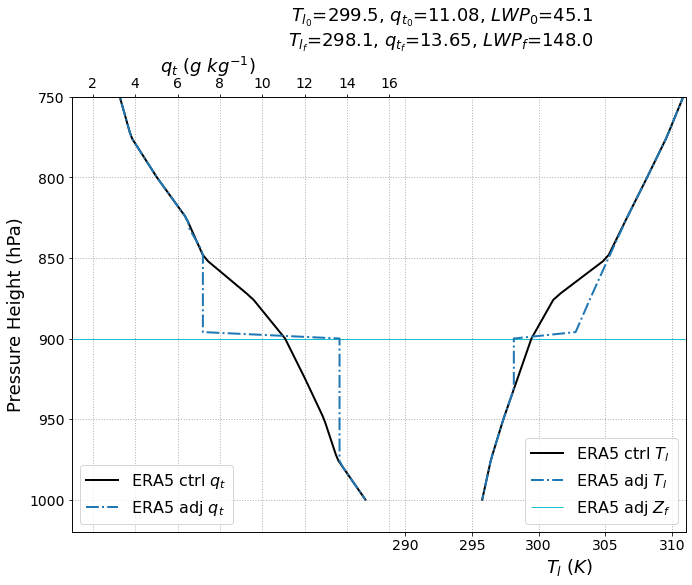

In [9]:
### Some parameters:

upbound = 3000 # upper bound (in meter) for the vertical integral
L_FT    = 500  # height above the inversion where ERA profiles don't "feel" the BL anymore
f_FT    = 3.0  # factor to determine the top of the region where we're fitting the line (zi + f_FT * L_FT ). 

try:
    target_lwp = np.nanmean(AMSR_lwp[idx_t2-1:idx_t2+1])
except:
    target_lwp = np.nanmean(AMSR_lwp[idx_t2:idx_t2+2])  
# target_lwp   = 80                                      

### Initial guesses
ff0    = 3.4  # initial f0 parameter
TL_diff= 8   # initial delta_Tl @Zinv
QT_diff= 8   # initial delta_QT @Zinv
CTH0 = Zi = CTH_target = 1100 # ERA_ZINV
idx_zi = np.nanmax( np.where( abs(ERA_z - Zi) == np.nanmin(abs(ERA_z - Zi)) ) )
TL_ML0 = ERA_Tl[idx_zi]  # initial Tl @Zinv
QT_ML0 = ERA_qt[idx_zi]  # # initial QT @Zinv

### bounds for initial guesses:
# bnds = ((0, 5000), (np.nanmin(ERA_Tl[idx_zi:]), 500), (0, np.nanmax(ERA_qt[idx_zi:])+.7), (0, 1e12), (0, 60), (1, 20))
bnds = ((0, 5000), (200, 500), (0, 40), (0, 1e12), (0, 60), (0, 20))

TL_o_f2, QT_o_f2, QL_o_f, T_o_f, opt_vals = run_and_plot()

In [10]:
### Calculate the Outputs after confirming the results from the plot:

ERA_Z = ERA_z; ERA_TL = ERA_Tl; ERA_QT = ERA_qt; LWP_target = target_lwp;

#    CTH = CTH0; TL_ML = TL_ML0; QT_ML = QT_ML0; ff = ff0; TL_diff = TL_diff; QT_diff = QT_diff
CTH = opt_vals[0]; TL_ML = opt_vals[1]; QT_ML = opt_vals[2]; ff = opt_vals[3]; TL_diff = opt_vals[4]; QT_diff = opt_vals[5]

TL_o, QT_o = produce_ERA5_profile(ERA_Z, ERA_TL, ERA_QT, CTH, TL_ML, QT_ML,L_FT, TL_diff, QT_diff)    

# compute LWC and Tadj by using saturation adjustment at each height
QL_o_adj, T_o_adj = sat_adj(ERA_Z, TL_o, QT_o, ERA_p)

# Calculate Trho, which is the density temperature. It's the same as the virtual temperature except for the inclusion of 
# the density change due to liquid water loading. This will keep the vertically-integrated density from drifting too far 
# from that of ERA5, which is a more physical constraint than the one on Tl.
#T_o_adj  = TL_o - g * ERA_Z / Cp + (Lv / Cp) * QL_o_adj / 1000
T_o_rho    = T_o_adj * (1 + 0.61 * (QT_o - QL_o_adj) / 1000 - QL_o_adj / 1000)
ERA_T_rho  = ERA_t   * (1 + 0.61 * ERA_q / 1000 - ERA_lwc / 1000)

# Compute the LWP of the modified profiles and other vertical integrals
LWP_adj       = z_integral(QL_o_adj, ERA_Z, ERA_RHO, upbound)
LWP_ERA       = z_integral(ERA_lwc,  ERA_Z, ERA_RHO, upbound)
TWP_o         = z_integral(QT_o,     ERA_Z, ERA_RHO, upbound)
TWP_ERA       = z_integral(ERA_QT,   ERA_Z, ERA_RHO, upbound)
TL_o_zint     = z_integral(TL_o,     ERA_Z, ERA_RHO, upbound)
TL_ERA_zint   = z_integral(ERA_TL,   ERA_Z, ERA_RHO, upbound)
To_rho_zint   = z_integral(T_o_rho,  ERA_Z, ERA_RHO, upbound)
T_rho_ERA_zint= z_integral(ERA_T_rho,  ERA_Z, ERA_RHO, upbound)    
ones          = ERA_Z.copy()
ones[:]       = 1
RHO_zint      = z_integral(ones,   ERA_Z, ERA_RHO, upbound)

# Output a (positive) number that tells how well the resulting profile matches LWP_target 
# we have a few targets that we want to match: LWP_adj, vertically-integrated TL_o(z), vertically-integrated QT_o(z) & CTH 

# First, factors; which have a general formula of [1 / (variable uncertainty) ] ^ 2
# uncertainties are small values for the deviation of the integrated variables 
# (with each scaled by int_z rho*dz and then squared) 
# This would essentially force the vertical integrals to be conserved in the new profiles.

# For fac2, using the factor of Lv/Cp forces some equivalence between moisture and temperature errors.  
# The default ff value is equal to 0.3 kg/m2 because it's probably a couple percent of the TWP.
# Modifying it has minimal effect on the solution.  
fac1 = 1 / ( 10.  ** 2 )
#    fac1 = 1e-4 / ( 10.  ** 2 )
fac2 = (1 / ( ff ** 2 ) ) * ( Cp / Lv ) ** 2 / 100
fac3 = 1 / ( (ff * 1000) ** 2 )
fac4 = 1 / ( 20.  ** 2 )

output = fac1 * (LWP_target - LWP_adj) ** 2 + fac2 * (To_rho_zint - T_rho_ERA_zint) ** 2 + \
         fac3 * (TWP_o      - TWP_ERA) ** 2 + fac4 * (CTH_target - CTH) ** 2

In [11]:
print(output, fac1 * (LWP_target - LWP_adj) ** 2, fac2 * (To_rho_zint - T_rho_ERA_zint) ** 2, \
              fac3 * (TWP_o      - TWP_ERA) ** 2, fac4 * (CTH_target - CTH) ** 2)

2.2000685908729977e-05 6.898328382976355e-10 1.5017783353751954e-05 6.982212722139124e-06 6.010176540291072e-19


## Replace the variables in the Forcing file with the sharpened variables

In [12]:
time2 = idx_t / 24 # duration of nudging (in unit of day)

## Replace forcing with an original one to avoid any issue in the existing file
os.popen('cp ' + forcing_fname + ' ./' + subdir + '/' ).read()

ug_forc3 = ug_forc2.copy()
vg_forc3 = vg_forc2.copy()
ug_forc3[idx_zi:] = ug_forc3[idx_zi]
vg_forc3[idx_zi:] = vg_forc3[idx_zi]

T_o_f_new = T_o_f - (Lv / Cp) * QL_o_f / 1000

added_time = 0 # unit: hour. Continue nudging after the desired time just to be sure

forcing_file = './' + subdir + '/' + forcing_fname
forcing_data = Dataset(forcing_file, mode='r+')

forcing_T    = forcing_data.variables['T'][:]      # liquid Water Temperature From ERA-5 (converted from theta_l, for initialization)
forcing_q    = forcing_data.variables['q'][:]      # Total water Mass Mixing Ratio From ERA-5
#forcing_z    = forcing_data.variables['z'][:]     
forcing_u    = forcing_data.variables['u'][:]      
forcing_v    = forcing_data.variables['v'][:]      
forcing_ug   = forcing_data.variables['ug'][:]      
forcing_vg   = forcing_data.variables['vg'][:]      

adj = T_time[0] +  time2 + added_time / 24
idx_adj = np.where( abs(T_time - adj) == np.nanmin( abs(T_time - adj) ) )[0][0]

for i in range(idx_adj + 1):
    forcing_q[i,:,0,0]    = abs(QT_o_f2) /1000
    forcing_T[i,:,0,0]    = T_o_f_new
    forcing_u[i,:,0,0]    = u_forc
    forcing_v[i,:,0,0]    = v_forc
    forcing_ug[i,:,0,0]   = ug_forc3
    forcing_vg[i,:,0,0]   = vg_forc3

forcing_data.variables['T'][:]     = forcing_T
forcing_data.variables['q'][:]     = forcing_q
forcing_data.variables['Tref'][:]  = forcing_T
forcing_data.variables['qref'][:]  = forcing_q
forcing_data.variables['Tinit'][:] = forcing_T
forcing_data.variables['qinit'][:] = forcing_q
forcing_data.variables['u'][:]     = forcing_u
forcing_data.variables['v'][:]     = forcing_v
forcing_data.variables['ug'][:]    = forcing_ug 
forcing_data.variables['vg'][:]    = forcing_vg

forcing_data.close()

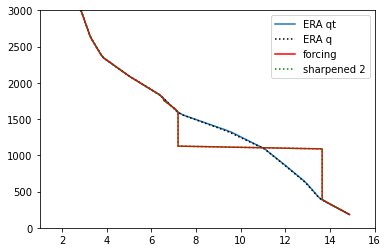

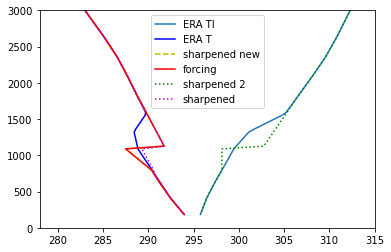

In [14]:
forcing_data = Dataset(forcing_file)

forcing_T    = forcing_data.variables['T'][:]      # liquid Water Temperature From ERA-5 (converted from theta_l, for initialization)
forcing_q    = forcing_data.variables['q'][:]      # Total water Mass Mixing Ratio From ERA-5
forcing_qref = forcing_data.variables['qref'][:]      # Ref. Mass Mixing Ratio From ERA-5
forcing_z    = forcing_data.variables['z'][:]      # water Vapor Mass Mixing Ratio From ERA-5
T_o_f_new    = T_o_f - (Lv / Cp) * QL_o_f / 1000


#####
plt.figure()
plt.plot(ERA_qt, ERA_z, label='ERA qt')
plt.plot(ERA_q, ERA_z, 'k:', label='ERA q')
plt.plot(forcing_q[idx_t,:,0,0]*1000, forcing_z[idx_t,:,0,0], 'r', label='forcing')
plt.plot(QT_o_f2, ERA_z,':g', label='sharpened 2')
plt.xlim(1,16)
plt.ylim(0, 3000)
plt.legend()
plt.show()

######
plt.figure()
plt.plot(ERA_Tl, ERA_z, label='ERA Tl')
plt.plot(ERA_t, ERA_z,'b', label='ERA T')
plt.plot(T_o_f_new, ERA_z,'--y', label='sharpened new')
plt.plot(forcing_T[idx_t,:,0,0], forcing_z[idx_t,:,0,0], 'r', label='forcing')
plt.plot(TL_o_f2, ERA_z,':g', label='sharpened 2')
plt.plot(T_o_f, ERA_z,':m', label='sharpened')
plt.xlim(278, 315)
plt.ylim(0, 3000)
plt.legend()
plt.show()

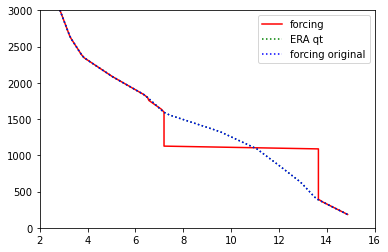

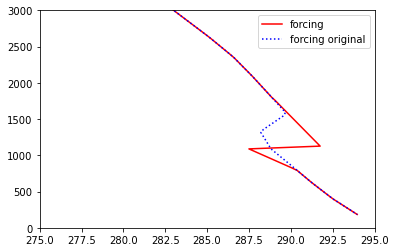

In [15]:
idx_t_2 = idx_t

forcing_data = Dataset(forcing_file)


forcing_T    = forcing_data.variables['T'][:]      # liquid Water Temperature From ERA-5 (converted from theta_l, for initialization)
forcing_q    = forcing_data.variables['q'][:]      # Total water Mass Mixing Ratio From ERA-5
forcing_qref = forcing_data.variables['qref'][:]      # Ref. Mass Mixing Ratio From ERA-5
forcing_z    = forcing_data.variables['z'][:]      # water Vapor Mass Mixing Ratio From ERA-5
T_o_f_new    = T_o_f - (Lv / Cp) * QL_o_f / 1000


####
forcing_file_org = forcing_fname
forcing_data_org = Dataset(forcing_file_org)

forcing_T_org    = forcing_data_org.variables['T'][:]      # liquid Water Temperature From ERA-5 (converted from theta_l, for initialization)
forcing_q_org    = forcing_data_org.variables['q'][:]      # Total water Mass Mixing Ratio From ERA-5
forcing_z_org    = forcing_data_org.variables['z'][:]      # water Vapor Mass Mixing Ratio From ERA-5


#####
plt.figure()
plt.plot(forcing_q[idx_t_2,:,0,0]*1000, forcing_z[idx_t_2,:,0,0], 'r', label='forcing')
plt.plot(ERA_qt, ERA_z, 'g:', label='ERA qt')
plt.plot(forcing_q_org[idx_t_2,:,0,0]*1000, forcing_z_org[idx_t_2,:,0,0], 'b:', label='forcing original')
plt.xlim(2,16)
plt.ylim(0, 3000)
plt.legend()
plt.show()

######
plt.figure()
plt.plot(forcing_T[idx_t_2,:,0,0], forcing_z[idx_t_2,:,0,0], 'r', label='forcing')
plt.plot(forcing_T_org[idx_t_2,:,0,0], forcing_z_org[idx_t_2,:,0,0], 'b:', label='forcing original')
plt.xlim(275, 295)
plt.ylim(0, 3000)
plt.legend()
plt.show()

## Make sure that the forcing file was changed correctly:

In [16]:
forcing_data = Dataset(forcing_file)

## Read variables in the CSET forcing_data file:
lat      = forcing_data.variables['lat']             
lon      = forcing_data.variables['lon']
lev      = forcing_data.variables['lev']          
tsec     = forcing_data.variables['tsec'][:len(T_time)]     # Time in seconds after 00Z on nbdate"             
calday   = forcing_data.variables['calday'][:len(T_time)]   # Time in days since Jan. 01, 2019
year     = forcing_data.variables['year'][:len(T_time)]             
month    = forcing_data.variables['month'][:len(T_time)]             
day      = forcing_data.variables['day'][:len(T_time)]             
hour     = forcing_data.variables['hour'][:len(T_time)]             
#nbdate   = forcing_data.variables['nbdate'][:len(T_time)]   # yymmdd, Base Date, (Note that only two digit year is permitted.)            
#bdate    = forcing_data.variables['bdate'][:len(T_time)]    # yymmdd, Base Date, (Note that only two digit year is permitted.)            
phis     = forcing_data.variables['phis'][:len(T_time)]     # Surface Geopotential: m2/s2        
Ps       = forcing_data.variables['Ps'][:len(T_time)]       # Surface Pressure, Pa         
Ptend    = forcing_data.variables['Ptend'][:len(T_time)]      # tendency_of_surface_air_pressure           
Tg       = forcing_data.variables['Tg'][:len(T_time)]       # Surface Temperature (SST if over water): K
shflx    = forcing_data.variables['shflx'][:len(T_time)]           # Surface Sensible Heat Flux:
lhflx    = forcing_data.variables['lhflx'][:len(T_time)]           # Surface Latent Heat Flux:
Tsair    = forcing_data.variables['Tsair'][:len(T_time)]
qsrf     = forcing_data.variables['qsrf'][:len(T_time)]     # Surface Water Vapor Mass Mixing ratio (extrapolated to z=0): kg/kg
u_traj   = forcing_data.variables['u_traj'][:len(T_time)]
v_traj   = forcing_data.variables['v_traj'][:len(T_time)]
CTH      = forcing_data.variables['CTH'][:len(T_time)]      # MODIS cloud top height: km
u        = forcing_data.variables['u'][:len(T_time)]
v        = forcing_data.variables['v'][:len(T_time)]
ug       = forcing_data.variables['ug'][:len(T_time)]
vg       = forcing_data.variables['vg'][:len(T_time)]
omega    = forcing_data.variables['omega'][:len(T_time)]    # Vertical Pressure Velocity: Pa/s
T        = forcing_data.variables['T'][:len(T_time)]        # Liquid Water Temperature From ERA-5 (converted from theta_l, for initialization): K
q        = forcing_data.variables['q'][:len(T_time)]        # Total Water Mass Mixing Ratio From ERA-5
divT     = forcing_data.variables['divT'][:len(T_time)]     # Large-scale Horizontal Temperature Advection: K/s
divq     = forcing_data.variables['divq'][:len(T_time)]     # Large-scale Horizontal Advection of Water Vapor Mass Mixing Ratio: kg/s
z        = forcing_data.variables['z'][:len(T_time)]        # Geopotential height from ERA-5:
Tref     = forcing_data.variables['Tref'][:len(T_time)]     # 
qref     = forcing_data.variables['qref'][:len(T_time)]     #
Tinit    = forcing_data.variables['Tinit'][:len(T_time)]    # 
qinit    = forcing_data.variables['qinit'][:len(T_time)]    # 
o3mmr    = forcing_data.variables['o3mmr'][:len(T_time)]
Na_accum = forcing_data.variables['Na_accum'][:len(T_time)] # Accumulation mode aerosol number mixing ratio from MERRA2: 1/kg
qa_accum = forcing_data.variables['qa_accum'][:len(T_time)] # Accumulation mode aerosol mass mixing ratio from MERRA2: kg/kg

fday = calday - int(calday[0])
dummy, fday_mg = np.meshgrid(z[0,:,0,0], fday) # making meshgrid

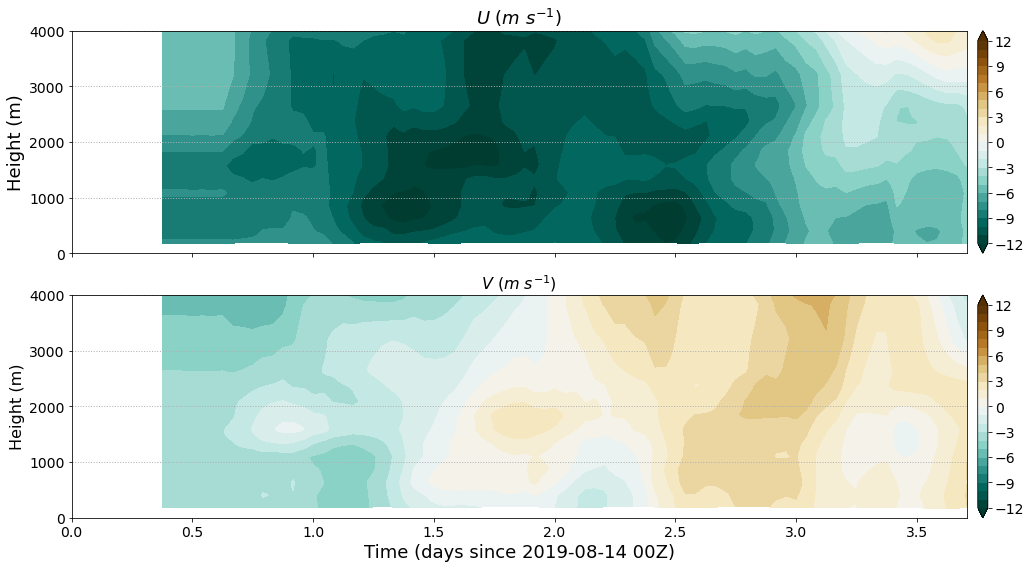

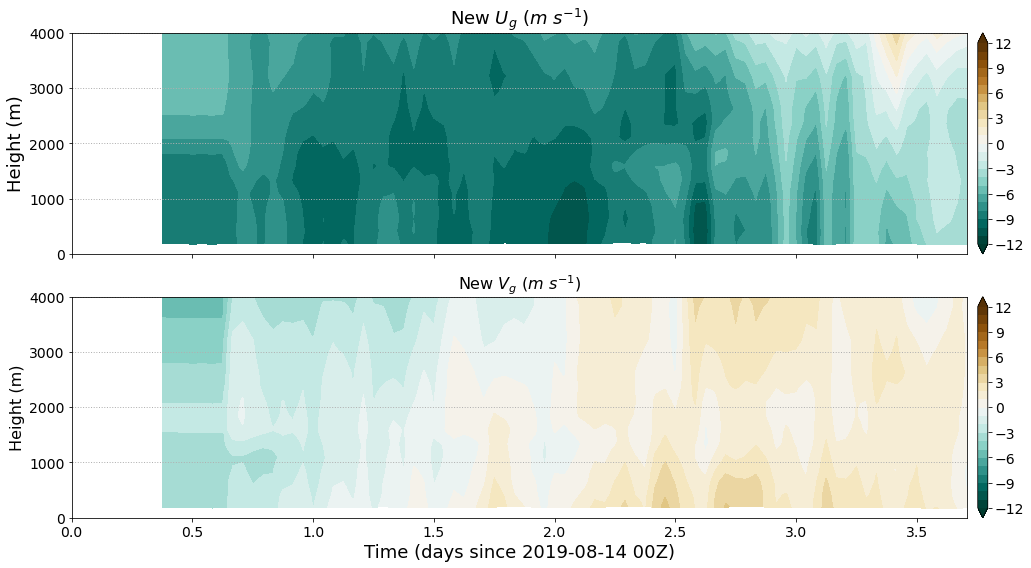

(array([], dtype=int64), array([], dtype=int64))
(array([], dtype=int64), array([], dtype=int64))
(array([], dtype=int64), array([], dtype=int64))
(array([], dtype=int64), array([], dtype=int64))


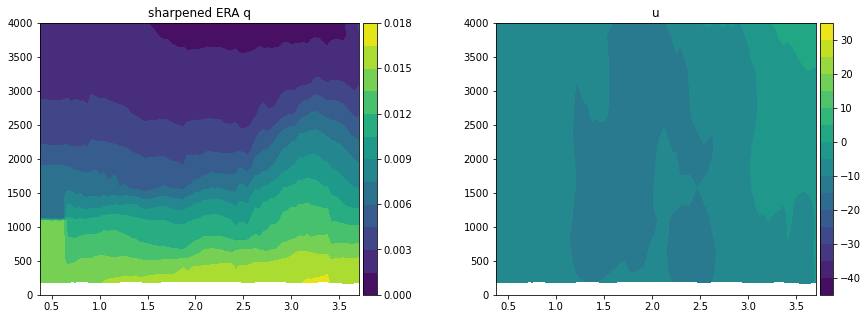

In [17]:
lngh = 15
box = 5
start = 0
xlim = fday[-1]

fig, axis = plt.subplots(2, 1,figsize=(16,8))

i = 0
axis[i].set_ylabel('Height (m)', fontsize = '18')
axis[i].set_title('$U$ ($m$ $s^{-1}$)', fontsize = '18')
axis[i].set_xlim([start, xlim])
axis[i].set_ylim([0, 4000])
axis[i].axes.get_xaxis().set_ticklabels([])
axis[i].tick_params(axis='both', which='major', labelsize=14)
axis[i].grid(linestyle=':', axis='y', linewidth=1)
#axis[i].axes.get_xaxis().set_visible(False)

i = 1
axis[i].set_ylabel('Height (m)', fontsize = '16')
axis[i].set_title('$V$ ($m$ $s^{-1}$)', fontsize = '16')# , (MBL: MERRA2-UHSAS log-log fit; FT: MERRA2 corrected)
axis[i].set_xlim([start, xlim])
axis[i].set_ylim([0, 4000])    
axis[i].set_xlabel('Time (days since '+init_time+')', fontsize = '18')
axis[i].tick_params(axis='both', which='major', labelsize=14)
axis[i].grid(linestyle=':', axis='y', linewidth=1)

#######
i = 0
clevs = np.arange(-12, 13, 1)
#    ticks = np.arange(270, 300.01, 4)
cc1 = axis[i].contourf(fday_mg, z[:,:,0,0], u[:,:,0,0], clevs, extend='both', cmap = 'BrBG_r')
cb = plt.colorbar(cc1, ax = axis[i], pad = 0.01)
cb.ax.tick_params(labelsize=14)

i = 1
clevs = np.arange(-12, 13, 1)
cc1 = axis[i].contourf(fday_mg, z[:,:,0,0], v[:,:,0,0], clevs, extend='both', cmap = 'BrBG_r')#, norm=matplotlib.colors.LogNorm())
cb = plt.colorbar(cc1, ax = axis[i], pad = 0.01)#, ticks=ticks)
cb.ax.tick_params(labelsize=14)


plt.tight_layout(w_pad=1)
#plt.savefig(casename + '_thermo_'+period+'.png' , format='png', dpi=200)
plt.show()


#############################
lngh = 15
box = 5
start = 0
xlim = fday[-1]

fig, axis = plt.subplots(2, 1,figsize=(16,8))

i = 0
axis[i].set_ylabel('Height (m)', fontsize = '18')
axis[i].set_title('New $U_g$ ($m$ $s^{-1}$)', fontsize = '18')
axis[i].set_xlim([start, xlim])
axis[i].set_ylim([0, 4000])
axis[i].axes.get_xaxis().set_ticklabels([])
axis[i].tick_params(axis='both', which='major', labelsize=14)
axis[i].grid(linestyle=':', axis='y', linewidth=1)
#axis[i].axes.get_xaxis().set_visible(False)

i = 1
axis[i].set_ylabel('Height (m)', fontsize = '16')
axis[i].set_title('New $V_g$ ($m$ $s^{-1}$)', fontsize = '16')# , (MBL: MERRA2-UHSAS log-log fit; FT: MERRA2 corrected)
axis[i].set_xlim([start, xlim])
axis[i].set_ylim([0, 4000])    
axis[i].set_xlabel('Time (days since '+init_time+')', fontsize = '18')
axis[i].tick_params(axis='both', which='major', labelsize=14)
axis[i].grid(linestyle=':', axis='y', linewidth=1)

#######
i = 0
clevs = np.arange(-12, 13, 1)
#    ticks = np.arange(270, 300.01, 4)
cc1 = axis[i].contourf(fday_mg, z[:,:,0,0], ug[:,:,0,0], clevs, extend='both', cmap = 'BrBG_r')
cb = plt.colorbar(cc1, ax = axis[i], pad = 0.01)
cb.ax.tick_params(labelsize=14)

i = 1
clevs = np.arange(-12, 13, 1)
cc1 = axis[i].contourf(fday_mg, z[:,:,0,0], vg[:,:,0,0], clevs, extend='both', cmap = 'BrBG_r')#, norm=matplotlib.colors.LogNorm())
cb = plt.colorbar(cc1, ax = axis[i], pad = 0.01)#, ticks=ticks)
cb.ax.tick_params(labelsize=14)


plt.tight_layout(w_pad=1)
#plt.savefig(casename + '_thermo_'+period+'.png' , format='png', dpi=200)
plt.show()



##########################
fig, axis = plt.subplots(1, 2,figsize=(15,5))
jj = 0
cc1 = axis[jj].contourf(fday_mg, z[:,:,0,0], q[:,:,0,0], 15)
cb = plt.colorbar(cc1, ax = axis[jj], pad = 0.01)#, ticks=ticks)
axis[jj].set_ylim([0, 4000])
axis[jj].set_title('sharpened ERA q')

jj = 1
cc1 = axis[jj].contourf(fday_mg, z[:,:,0,0], u[:,:,0,0], 15)
cb = plt.colorbar(cc1, ax = axis[jj], pad = 0.01)#, ticks=ticks)
axis[jj].set_ylim([0, 4000])
axis[jj].set_title('u')


## Make sure there is no NaN in the variables:
var_others = ['T', 'q', 'Tref', 'qref']
for i in range(len(var_others)):
    var_test = forcing.variables[var_others[i]][:] # Accumulation mode aerosol number mixing ratio from MERRA2: 1/kg
    print(np.where(np.isnan(var_test[:,:,0,0]) == 1))

# 2. Creating forcing file for startup simulation

[Functions](#Functions)

## Define parameters and Read input files

In [18]:
forcing_fname = 'Forcings_NEP_'    + region + '_' + str(yyyy) + f"{mm:02n}" + f"{dd:02n}" + '_STARTUP.nc'
traj_for_fname= 'st_72h_forward_'  + region + '_' + str(yyyy) + f"{mm:02n}" + f"{dd:02n}" + '.nc'
traj_bck_fname= 'st_48h_backward_' + region + '_' + str(yyyy) + f"{mm:02n}" + f"{dd:02n}" + '.nc'
init_time     = str(yyyy) + '-' + f"{mm:02n}" + '-' + f"{dd:02n}" + ' 00Z' 
bdate         = nbdate = int(str(yyyy)[2:] + f"{mm:02n}" + f"{dd:02n}")

subdir        = 'Sharpened'

idx_t         = HH_adj - HH

# constants from SAM's SRC/params.f90
Rd    = 287
Cp    = 1004   # specific heat of dry air at constant pressure: J/kg/K, 1005.7 
Lv    = 2.5e6  # latent heat of vaporization: J/kg
g     = 9.81   # gravitation
Rd_cp = Rd / Cp  # 0.286


## Replace forcing with an original one to avoid any issue in the existing file
os.popen('cp ' + forcing_fname + ' ./' + subdir + '/' ).read()

##### read various files
forcing     = Dataset('./' + subdir + '/' + forcing_fname)

# These are trajectory files:
Traj_data  = Dataset('../Lagrangian_project/' + traj_for_fname)
# Just in case there is a backward trajectory:
# Traj_datab = Dataset('../Lagrangian_project/' + traj_bck_fname)

In [19]:
###### Read various satellite and reanalysis ########
## Only initialization time!

### Time
if traj_dirc == ['forward', 'backward']:
    T_time = np.concatenate( ( (Traj_datab.variables['time'][(-HH + 1):] - Traj_datab.variables['time'][-HH + 1]) / 24, \
                                  (Traj_data.variables['time'][:] + HH) / 24), axis=0)
else:
    T_time = (Traj_data.variables['time'][:] + HH) / 24


time = T_time[idx_t]   # sharpening time in units of day

## Read LWP and CTH.
SSMI_lwp     = read_var_1D('SSMI_LWP') * 1000  # Cloud Liquid Water: converted to g /m2
idx          = np.where(np.isnan(SSMI_lwp) == 0)[0]
SSMI_lwp     = SSMI_lwp[idx]

T_time2      = T_time[idx]
idx_t2       = np.where( abs(T_time2 - time) == np.nanmin( abs(T_time2 - time) ) )[0][0]

AMSR_lwp     = read_var_1D('AMSR_LWP') * 1000  # Cloud Liquid Water: converted to g /m2
idx          = np.where(np.isnan(AMSR_lwp) == 0)[0]
AMSR_lwp     = AMSR_lwp[idx]

CERES_cth    = read_var_1D('CERES_cldhght_top_low_1h')[idx_t] * 1000

MODIS_CTH    = read_var_1D('MODIS_CTH') * 1000
idx          = np.where(np.isnan(MODIS_CTH) == 0)[0]
MODIS_CTH    = MODIS_CTH[idx]


### MERRA
MERRA_RHO    = read_var_2D('MERRA_AIRDENS')[idx_t,:]  # air_density: kg/m3                     
MERRA_H      = read_var_2D('MERRA_H')[idx_t,:]        # mid_layer_heights

### ERA
ERA_z2    = read_var_2D('ERA_z')[idx_t,:] / 10        # geopotential: converted from m**2 s**-2 to m
ERA_t2    = read_var_2D('ERA_t')[idx_t,:]             # air_temperature: K
ERA_q2    = read_var_2D('ERA_MR')[idx_t,:] * 1000     # specific_humidity: converted to g/kg
ERA_r2    = read_var_2D('ERA_r')[idx_t,:]             # relative_humidity: %
ERA_crwc2 = read_var_2D('ERA_crwc')[idx_t,:] * 1000   # Specific rain water content: converted to g kg**-1
ERA_clwc2 = read_var_2D('ERA_clwc')[idx_t,:] * 1000   # Specific cloud water content: converted to g kg**-1
ERA_p2    = Traj_data.variables['level'][:]           # air_pressure: mb

            
## Forcing variables:
ERA_z   =  forcing.variables['z'][idx_t,:,0,0]   # Geopotential height from ERA-5:
p_interp=  forcing.variables['lev'][:]           # air pressure
u_forc  =  forcing.variables['u'][idx_t,:,0,0]
v_forc  =  forcing.variables['v'][idx_t,:,0,0]
ug_forc =  forcing.variables['ug'][idx_t,:,0,0]
vg_forc =  forcing.variables['vg'][idx_t,:,0,0]
omega   =  forcing.variables['omega'][idx_t,:,0,0]
lat_forc=  forcing.variables['lat'][:]

## Creating constant wind profiles based on geostrophic winds:

In [20]:
##### Calculate density for forcing
Forcing_RHO = ERA_z.copy()
Forcing_RHO[:] = np.nan
f_RHO = interpolate.interp1d(MERRA_H, MERRA_RHO, fill_value='extrapolate')
Forcing_RHO = f_RHO(np.array(ERA_z))

#### Calculate W from omega:
W_forc = -omega / (Forcing_RHO * 9.81)

#### Calculate du/dz and dv/dz
du_dz = u_forc.copy()
dv_dz = u_forc.copy()
du_dz[:] = np.nan
dv_dz[:] = np.nan
du_dz[1:] = (u_forc[:-1] - u_forc[1:]) / (ERA_z[:-1] - ERA_z[1:])
dv_dz[1:] = (v_forc[:-1] - v_forc[1:]) / (ERA_z[:-1] - ERA_z[1:])
du_dz[0] = du_dz[1]
dv_dz[0] = dv_dz[1]

#### Calculate ug and vg explicitly above the boundary layer by including forcing due to the effect of subsidence
f_cor    = (4 * math.pi / 86400.) * math.sin( lat_forc[0] * math.pi / 180. )   # coriolis parameter
vg_forc2 = v_forc - (W_forc * du_dz) / f_cor
ug_forc2 = u_forc + (W_forc * dv_dz) / f_cor

In [21]:
# interpolate from ERA5 coarse vertical grid to fine grid:
ERA_t    = interp_to_forc_Z(ERA_p2, ERA_t2, p_interp/100)
ERA_q    = interp_to_forc_Z(ERA_p2, ERA_q2, p_interp/100)
ERA_r    = interp_to_forc_Z(ERA_p2, ERA_r2, p_interp/100)
ERA_p    = interp_to_forc_Z(ERA_p2, ERA_p2, p_interp/100)
ERA_crwc = interp_to_forc_Z(ERA_p2, ERA_crwc2, p_interp/100)
ERA_clwc = interp_to_forc_Z(ERA_p2, ERA_clwc2, p_interp/100)

ERA_lwc  = ERA_crwc + ERA_clwc             # liquid water mixing ratio (rain water + liquid cloud water)
ERA_qt   = ERA_q + ERA_lwc                 # Total water: g/kg


# interpolate MERRA2 RHO to ERA z-grid:
f_RHO    = interpolate.interp1d(MERRA_H, MERRA_RHO)
ERA_RHO  = f_RHO(np.array(ERA_z))

## Calculate liquid water static energy divided by Cp
ERA_Tl   = ERA_t + g * ERA_z / Cp - (Lv / Cp) * ERA_lwc / 1000

In [22]:
###############################################################
### Calculate inversion height (min of dtheta/dz * dRH/dz)
ERA_THETA  = ERA_t * (1000 / ERA_p) ** (Rd_cp)
ERA_THETAL = ERA_THETA - (ERA_THETA / ERA_t) * (Lv / Cp) * ERA_lwc / 1000

dz_ERA     = ERA_z.copy()
dz_ERA[:]  = np.nan
dz_ERA[1:] = ERA_z[:-1] - ERA_z[1:]
ERA_ZINV   = inv_h(ERA_THETAL, ERA_r, dz_ERA, ERA_z)

ERA_ql2, ERA_t2 = sat_adj(ERA_z, ERA_Tl, ERA_qt, ERA_p)

# plt.figure()
# plt.plot(ERA_ql2, ERA_z)
# plt.plot(ERA_lwc, ERA_z, ':')
# #plt.xlim(-0.01,0.23)
# plt.ylim(0, 3000)

# plt.figure()
# plt.plot(ERA_t2, ERA_z)
# plt.plot(ERA_t, ERA_z)
# plt.xlim(282, 295)
# plt.ylim(0, 3000)

# plt.figure()
# plt.plot(ERA_qt, ERA_z)
# plt.plot(np.array([sat_q(ERA_t[i], ERA_p[i]) for i in range(ERA_t.shape[0])]), ERA_z, ':')
# plt.xlim(2,17)
# plt.ylim(0, 3000)


[Functions](#Functions)

     fun: 0.0004175748127537844
     jac: array([-1.63709046e-10, -6.58701424e-03,  8.68222558e-03, -1.25383285e-04,
        0.00000000e+00,  4.06801453e-04])
 message: 'Optimization terminated successfully'
    nfev: 217
     nit: 30
    njev: 30
  status: 0
 success: True
       x: array([1099.99999996,  297.37877139,   13.0305551 ,    6.65899609,
          0.        ,    5.26166595])
Initial values:  1100 299.2518286023988 11.198329523571118 3.4 8 8
Final values:  [1099.99999996  297.37877139   13.0305551     6.65899609    0.
    5.26166595]


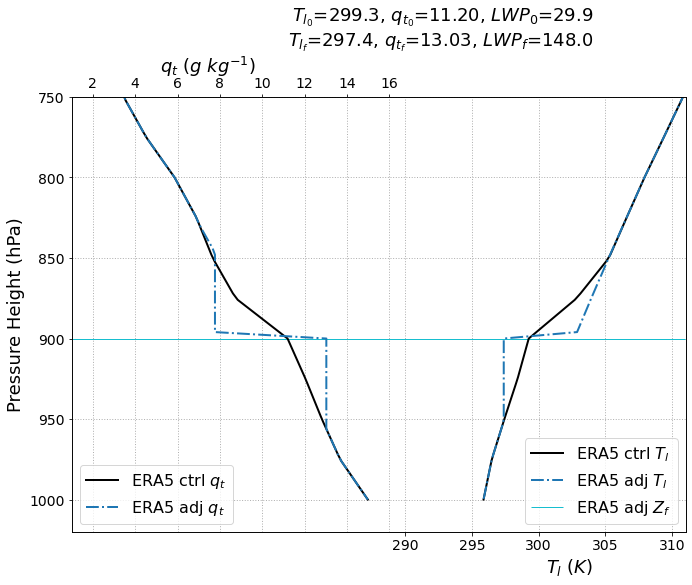

In [23]:
### Some parameters:

upbound = 3000 # upper bound (in meter) for the vertical integral
L_FT    = 500  # height above the inversion where ERA profiles don't "feel" the BL anymore
f_FT    = 3.0  # factor to determine the top of the region where we're fitting the line (zi + f_FT * L_FT ). 

try:
    target_lwp = np.nanmean(AMSR_lwp[idx_t2-1:idx_t2+1])
except:
    target_lwp = np.nanmean(AMSR_lwp[idx_t2:idx_t2+2])  
# target_lwp   = 80                                      

### Initial guesses
ff0    = 3.4  # initial f0 parameter
TL_diff= 8   # initial delta_Tl @Zinv
QT_diff= 8   # initial delta_QT @Zinv
CTH0 = Zi = CTH_target = 1100 # ERA_ZINV
idx_zi = np.nanmax( np.where( abs(ERA_z - Zi) == np.nanmin(abs(ERA_z - Zi)) ) )
TL_ML0 = ERA_Tl[idx_zi]  # initial Tl @Zinv
QT_ML0 = ERA_qt[idx_zi]  # # initial QT @Zinv

### bounds for initial guesses:
bnds = ((0, 5000), (200, 500), (0, 40), (0, 1e12), (0, 60), (0, 20))

TL_o_f2, QT_o_f2, QL_o_f, T_o_f, opt_vals = run_and_plot()

In [24]:
### Calculate the Outputs after confirming the results from the plot:

ERA_Z = ERA_z; ERA_TL = ERA_Tl; ERA_QT = ERA_qt; LWP_target = target_lwp;

#    CTH = CTH0; TL_ML = TL_ML0; QT_ML = QT_ML0; ff = ff0; TL_diff = TL_diff; QT_diff = QT_diff
CTH = opt_vals[0]; TL_ML = opt_vals[1]; QT_ML = opt_vals[2]; ff = opt_vals[3]; TL_diff = opt_vals[4]; QT_diff = opt_vals[5]

TL_o, QT_o = produce_ERA5_profile(ERA_Z, ERA_TL, ERA_QT, CTH, TL_ML, QT_ML,L_FT, TL_diff, QT_diff)    

# compute LWC and Tadj by using saturation adjustment at each height
QL_o_adj, T_o_adj = sat_adj(ERA_Z, TL_o, QT_o, ERA_p)

# Calculate Trho, which is the density temperature. It's the same as the virtual temperature except for the inclusion of 
# the density change due to liquid water loading. This will keep the vertically-integrated density from drifting too far 
# from that of ERA5, which is a more physical constraint than the one on Tl.
#T_o_adj  = TL_o - g * ERA_Z / Cp + (Lv / Cp) * QL_o_adj / 1000
T_o_rho    = T_o_adj * (1 + 0.61 * (QT_o - QL_o_adj) / 1000 - QL_o_adj / 1000)
ERA_T_rho  = ERA_t   * (1 + 0.61 * ERA_q / 1000 - ERA_lwc / 1000)

# Compute the LWP of the modified profiles and other vertical integrals
LWP_adj       = z_integral(QL_o_adj, ERA_Z, ERA_RHO, upbound)
LWP_ERA       = z_integral(ERA_lwc,  ERA_Z, ERA_RHO, upbound)
TWP_o         = z_integral(QT_o,     ERA_Z, ERA_RHO, upbound)
TWP_ERA       = z_integral(ERA_QT,   ERA_Z, ERA_RHO, upbound)
TL_o_zint     = z_integral(TL_o,     ERA_Z, ERA_RHO, upbound)
TL_ERA_zint   = z_integral(ERA_TL,   ERA_Z, ERA_RHO, upbound)
To_rho_zint   = z_integral(T_o_rho,  ERA_Z, ERA_RHO, upbound)
T_rho_ERA_zint= z_integral(ERA_T_rho,  ERA_Z, ERA_RHO, upbound)    
ones          = ERA_Z.copy()
ones[:]       = 1
RHO_zint      = z_integral(ones,   ERA_Z, ERA_RHO, upbound)

# Output a (positive) number that tells how well the resulting profile matches LWP_target 
# we have a few targets that we want to match: LWP_adj, vertically-integrated TL_o(z), vertically-integrated QT_o(z) & CTH 

# First, factors; which have a general formula of [1 / (variable uncertainty) ] ^ 2
# uncertainties are small values for the deviation of the integrated variables 
# (with each scaled by int_z rho*dz and then squared) 
# This would essentially force the vertical integrals to be conserved in the new profiles.

# For fac2, using the factor of Lv/Cp forces some equivalence between moisture and temperature errors.  
# The default ff value is equal to 0.3 kg/m2 because it's probably a couple percent of the TWP.
# Modifying it has minimal effect on the solution.  
fac1 = 1 / ( 10.  ** 2 )
#    fac1 = 1e-4 / ( 10.  ** 2 )
fac2 = (1 / ( ff ** 2 ) ) * ( Cp / Lv ) ** 2 / 100
fac3 = 1 / ( (ff * 1000) ** 2 )
fac4 = 1 / ( 20.  ** 2 )

output = fac1 * (LWP_target - LWP_adj) ** 2 + fac2 * (To_rho_zint - T_rho_ERA_zint) ** 2 + \
         fac3 * (TWP_o      - TWP_ERA) ** 2 + fac4 * (CTH_target - CTH) ** 2

In [25]:
print(output, fac1 * (LWP_target - LWP_adj) ** 2, fac2 * (To_rho_zint - T_rho_ERA_zint) ** 2, \
              fac3 * (TWP_o      - TWP_ERA) ** 2, fac4 * (CTH_target - CTH) ** 2)

1.9949444384917327e-05 1.1141310476948077e-07 4.0164178623117894e-06 1.582161341783192e-05 4.136437706947406e-18


## Replace the variables in the Forcing file with the sharpened variables

In [26]:
## Replace forcing with an original one to avoid any issue in the existing file
os.popen('cp ' + forcing_fname + ' ./' + subdir + '/' ).read()

ug_forc3 = ug_forc2.copy()
vg_forc3 = vg_forc2.copy()
ug_forc3[idx_zi:] = ug_forc3[idx_zi]
vg_forc3[idx_zi:] = vg_forc3[idx_zi]

T_o_f_new = T_o_f - (Lv / Cp) * QL_o_f / 1000

added_time = 0 # unit: hour. Continue nudging after the desired time just to be sure

forcing_file = './' + subdir + '/' + forcing_fname
forcing_data = Dataset(forcing_file, mode='r+')

forcing_T    = forcing_data.variables['T'][:]      # liquid Water Temperature From ERA-5 (converted from theta_l, for initialization)
forcing_q    = forcing_data.variables['q'][:]      # Total water Mass Mixing Ratio From ERA-5
#forcing_z    = forcing_data.variables['z'][:]     
forcing_u    = forcing_data.variables['u'][:]      
forcing_v    = forcing_data.variables['v'][:]      
forcing_ug   = forcing_data.variables['ug'][:]      
forcing_vg   = forcing_data.variables['vg'][:]      

for i in range(forcing_q.shape[0]):
    forcing_q[i,:,0,0]    = abs(QT_o_f2) /1000
    forcing_T[i,:,0,0]    = T_o_f_new
    forcing_u[i,:,0,0]    = u_forc
    forcing_v[i,:,0,0]    = v_forc
    forcing_ug[i,:,0,0]   = ug_forc3
    forcing_vg[i,:,0,0]   = vg_forc3

forcing_data.variables['T'][:]     = forcing_T
forcing_data.variables['q'][:]     = forcing_q
forcing_data.variables['Tref'][:]  = forcing_T
forcing_data.variables['qref'][:]  = forcing_q
forcing_data.variables['Tinit'][:] = forcing_T
forcing_data.variables['qinit'][:] = forcing_q
forcing_data.variables['u'][:]     = forcing_u
forcing_data.variables['v'][:]     = forcing_v
forcing_data.variables['ug'][:]    = forcing_ug 
forcing_data.variables['vg'][:]    = forcing_vg

forcing_data.close()

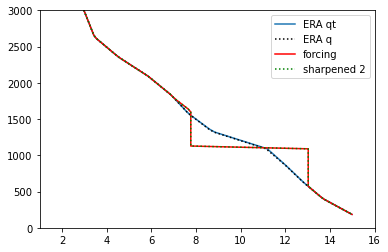

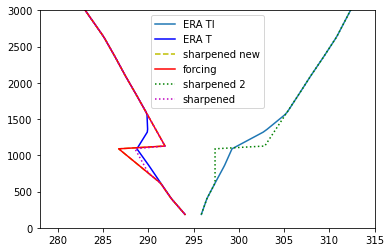

In [27]:
forcing_data = Dataset(forcing_file)

forcing_T    = forcing_data.variables['T'][:]      # liquid Water Temperature From ERA-5 (converted from theta_l, for initialization)
forcing_q    = forcing_data.variables['q'][:]      # Total water Mass Mixing Ratio From ERA-5
forcing_qref = forcing_data.variables['qref'][:]      # Ref. Mass Mixing Ratio From ERA-5
forcing_z    = forcing_data.variables['z'][:]      # water Vapor Mass Mixing Ratio From ERA-5
T_o_f_new    = T_o_f - (Lv / Cp) * QL_o_f / 1000


#####
plt.figure()
plt.plot(ERA_qt, ERA_z, label='ERA qt')
plt.plot(ERA_q, ERA_z, 'k:', label='ERA q')
plt.plot(forcing_q[idx_t,:,0,0]*1000, forcing_z[idx_t,:,0,0], 'r', label='forcing')
plt.plot(QT_o_f2, ERA_z,':g', label='sharpened 2')
plt.xlim(1,16)
plt.ylim(0, 3000)
plt.legend()
plt.show()

######
plt.figure()
plt.plot(ERA_Tl, ERA_z, label='ERA Tl')
plt.plot(ERA_t, ERA_z,'b', label='ERA T')
plt.plot(T_o_f_new, ERA_z,'--y', label='sharpened new')
plt.plot(forcing_T[idx_t,:,0,0], forcing_z[idx_t,:,0,0], 'r', label='forcing')
plt.plot(TL_o_f2, ERA_z,':g', label='sharpened 2')
plt.plot(T_o_f, ERA_z,':m', label='sharpened')
plt.xlim(278, 315)
plt.ylim(0, 3000)
plt.legend()
plt.show()

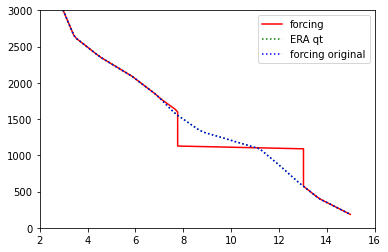

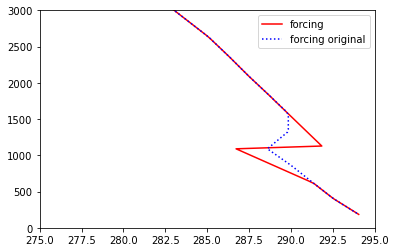

In [28]:
idx_t_2 = max(0, idx_t - 4) 

forcing_data = Dataset(forcing_file)


forcing_T    = forcing_data.variables['T'][:]      # liquid Water Temperature From ERA-5 (converted from theta_l, for initialization)
forcing_q    = forcing_data.variables['q'][:]      # Total water Mass Mixing Ratio From ERA-5
forcing_qref = forcing_data.variables['qref'][:]      # Ref. Mass Mixing Ratio From ERA-5
forcing_z    = forcing_data.variables['z'][:]      # water Vapor Mass Mixing Ratio From ERA-5
T_o_f_new    = T_o_f - (Lv / Cp) * QL_o_f / 1000


####
forcing_file_org = forcing_fname
forcing_data_org = Dataset(forcing_file_org)

forcing_T_org    = forcing_data_org.variables['T'][:]      # liquid Water Temperature From ERA-5 (converted from theta_l, for initialization)
forcing_q_org    = forcing_data_org.variables['q'][:]      # Total water Mass Mixing Ratio From ERA-5
forcing_z_org    = forcing_data_org.variables['z'][:]      # water Vapor Mass Mixing Ratio From ERA-5


#####
plt.figure()
plt.plot(forcing_q[idx_t_2,:,0,0]*1000, forcing_z[idx_t_2,:,0,0], 'r', label='forcing')
plt.plot(ERA_qt, ERA_z, 'g:', label='ERA qt')
plt.plot(forcing_q_org[idx_t_2,:,0,0]*1000, forcing_z_org[idx_t_2,:,0,0], 'b:', label='forcing original')
plt.xlim(2,16)
plt.ylim(0, 3000)
plt.legend()
plt.show()

######
plt.figure()
plt.plot(forcing_T[idx_t_2,:,0,0], forcing_z[idx_t_2,:,0,0], 'r', label='forcing')
plt.plot(forcing_T_org[idx_t_2,:,0,0], forcing_z_org[idx_t_2,:,0,0], 'b:', label='forcing original')
plt.xlim(275, 295)
plt.ylim(0, 3000)
plt.legend()
plt.show()

## Make sure that the forcing file was changed correctly:

In [29]:
forcing_data = Dataset(forcing_file)

## Read variables in the CSET forcing_data file:
lat      = forcing_data.variables['lat']             
lon      = forcing_data.variables['lon']
lev      = forcing_data.variables['lev']          
tsec     = forcing_data.variables['tsec'][:len(T_time)]     # Time in seconds after 00Z on nbdate"             
calday   = forcing_data.variables['calday'][:len(T_time)]   # Time in days since Jan. 01, 2019
year     = forcing_data.variables['year'][:len(T_time)]             
month    = forcing_data.variables['month'][:len(T_time)]             
day      = forcing_data.variables['day'][:len(T_time)]             
hour     = forcing_data.variables['hour'][:len(T_time)]             
#nbdate   = forcing_data.variables['nbdate'][:len(T_time)]   # yymmdd, Base Date, (Note that only two digit year is permitted.)            
#bdate    = forcing_data.variables['bdate'][:len(T_time)]    # yymmdd, Base Date, (Note that only two digit year is permitted.)            
phis     = forcing_data.variables['phis'][:len(T_time)]     # Surface Geopotential: m2/s2        
Ps       = forcing_data.variables['Ps'][:len(T_time)]       # Surface Pressure, Pa         
Ptend    = forcing_data.variables['Ptend'][:len(T_time)]      # tendency_of_surface_air_pressure           
Tg       = forcing_data.variables['Tg'][:len(T_time)]       # Surface Temperature (SST if over water): K
shflx    = forcing_data.variables['shflx'][:len(T_time)]           # Surface Sensible Heat Flux:
lhflx    = forcing_data.variables['lhflx'][:len(T_time)]           # Surface Latent Heat Flux:
Tsair    = forcing_data.variables['Tsair'][:len(T_time)]
qsrf     = forcing_data.variables['qsrf'][:len(T_time)]     # Surface Water Vapor Mass Mixing ratio (extrapolated to z=0): kg/kg
u_traj   = forcing_data.variables['u_traj'][:len(T_time)]
v_traj   = forcing_data.variables['v_traj'][:len(T_time)]
CTH      = forcing_data.variables['CTH'][:len(T_time)]      # MODIS cloud top height: km
u        = forcing_data.variables['u'][:len(T_time)]
v        = forcing_data.variables['v'][:len(T_time)]
ug       = forcing_data.variables['ug'][:len(T_time)]
vg       = forcing_data.variables['vg'][:len(T_time)]
omega    = forcing_data.variables['omega'][:len(T_time)]    # Vertical Pressure Velocity: Pa/s
T        = forcing_data.variables['T'][:len(T_time)]        # Liquid Water Temperature From ERA-5 (converted from theta_l, for initialization): K
q        = forcing_data.variables['q'][:len(T_time)]        # Total Water Mass Mixing Ratio From ERA-5
divT     = forcing_data.variables['divT'][:len(T_time)]     # Large-scale Horizontal Temperature Advection: K/s
divq     = forcing_data.variables['divq'][:len(T_time)]     # Large-scale Horizontal Advection of Water Vapor Mass Mixing Ratio: kg/s
z        = forcing_data.variables['z'][:len(T_time)]        # Geopotential height from ERA-5:
Tref     = forcing_data.variables['Tref'][:len(T_time)]     # 
qref     = forcing_data.variables['qref'][:len(T_time)]     #
Tinit    = forcing_data.variables['Tinit'][:len(T_time)]    # 
qinit    = forcing_data.variables['qinit'][:len(T_time)]    # 
o3mmr    = forcing_data.variables['o3mmr'][:len(T_time)]
Na_accum = forcing_data.variables['Na_accum'][:len(T_time)] # Accumulation mode aerosol number mixing ratio from MERRA2: 1/kg
qa_accum = forcing_data.variables['qa_accum'][:len(T_time)] # Accumulation mode aerosol mass mixing ratio from MERRA2: kg/kg

fday = calday - int(calday[0])
dummy, fday_mg = np.meshgrid(z[0,:,0,0], fday) # making meshgrid

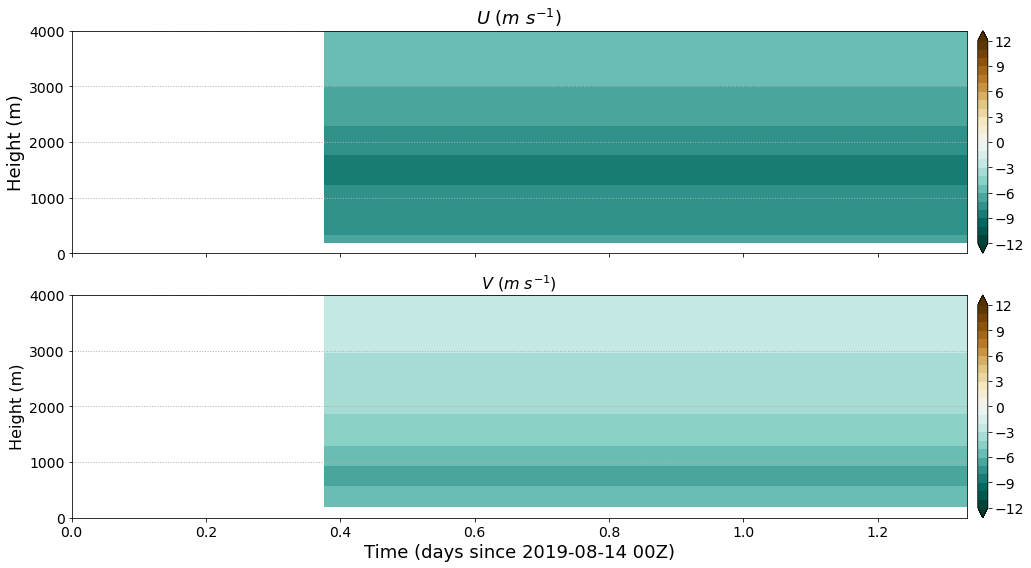

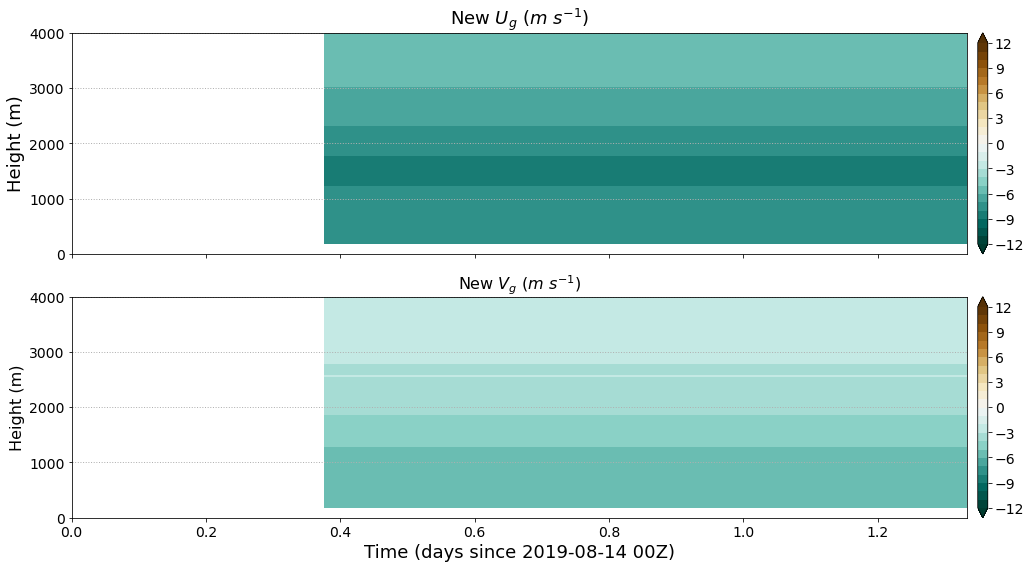

(array([], dtype=int64), array([], dtype=int64))
(array([], dtype=int64), array([], dtype=int64))
(array([], dtype=int64), array([], dtype=int64))
(array([], dtype=int64), array([], dtype=int64))


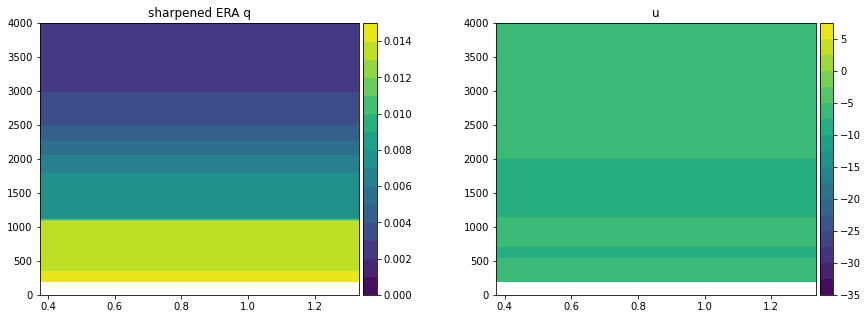

In [30]:
lngh = 15
box = 5
start = 0
xlim = fday[-1]

fig, axis = plt.subplots(2, 1,figsize=(16,8))

i = 0
axis[i].set_ylabel('Height (m)', fontsize = '18')
axis[i].set_title('$U$ ($m$ $s^{-1}$)', fontsize = '18')
axis[i].set_xlim([start, xlim])
axis[i].set_ylim([0, 4000])
axis[i].axes.get_xaxis().set_ticklabels([])
axis[i].tick_params(axis='both', which='major', labelsize=14)
axis[i].grid(linestyle=':', axis='y', linewidth=1)
#axis[i].axes.get_xaxis().set_visible(False)

i = 1
axis[i].set_ylabel('Height (m)', fontsize = '16')
axis[i].set_title('$V$ ($m$ $s^{-1}$)', fontsize = '16')# , (MBL: MERRA2-UHSAS log-log fit; FT: MERRA2 corrected)
axis[i].set_xlim([start, xlim])
axis[i].set_ylim([0, 4000])    
axis[i].set_xlabel('Time (days since '+init_time+')', fontsize = '18')
axis[i].tick_params(axis='both', which='major', labelsize=14)
axis[i].grid(linestyle=':', axis='y', linewidth=1)

#######
i = 0
clevs = np.arange(-12, 13, 1)
#    ticks = np.arange(270, 300.01, 4)
cc1 = axis[i].contourf(fday_mg, z[:,:,0,0], u[:,:,0,0], clevs, extend='both', cmap = 'BrBG_r')
cb = plt.colorbar(cc1, ax = axis[i], pad = 0.01)
cb.ax.tick_params(labelsize=14)

i = 1
clevs = np.arange(-12, 13, 1)
cc1 = axis[i].contourf(fday_mg, z[:,:,0,0], v[:,:,0,0], clevs, extend='both', cmap = 'BrBG_r')#, norm=matplotlib.colors.LogNorm())
cb = plt.colorbar(cc1, ax = axis[i], pad = 0.01)#, ticks=ticks)
cb.ax.tick_params(labelsize=14)


plt.tight_layout(w_pad=1)
#plt.savefig(casename + '_thermo_'+period+'.png' , format='png', dpi=200)
plt.show()


#############################
lngh = 15
box = 5
start = 0
xlim = fday[-1]

fig, axis = plt.subplots(2, 1,figsize=(16,8))

i = 0
axis[i].set_ylabel('Height (m)', fontsize = '18')
axis[i].set_title('New $U_g$ ($m$ $s^{-1}$)', fontsize = '18')
axis[i].set_xlim([start, xlim])
axis[i].set_ylim([0, 4000])
axis[i].axes.get_xaxis().set_ticklabels([])
axis[i].tick_params(axis='both', which='major', labelsize=14)
axis[i].grid(linestyle=':', axis='y', linewidth=1)
#axis[i].axes.get_xaxis().set_visible(False)

i = 1
axis[i].set_ylabel('Height (m)', fontsize = '16')
axis[i].set_title('New $V_g$ ($m$ $s^{-1}$)', fontsize = '16')# , (MBL: MERRA2-UHSAS log-log fit; FT: MERRA2 corrected)
axis[i].set_xlim([start, xlim])
axis[i].set_ylim([0, 4000])    
axis[i].set_xlabel('Time (days since '+init_time+')', fontsize = '18')
axis[i].tick_params(axis='both', which='major', labelsize=14)
axis[i].grid(linestyle=':', axis='y', linewidth=1)

#######
i = 0
clevs = np.arange(-12, 13, 1)
#    ticks = np.arange(270, 300.01, 4)
cc1 = axis[i].contourf(fday_mg, z[:,:,0,0], ug[:,:,0,0], clevs, extend='both', cmap = 'BrBG_r')
cb = plt.colorbar(cc1, ax = axis[i], pad = 0.01)
cb.ax.tick_params(labelsize=14)

i = 1
clevs = np.arange(-12, 13, 1)
cc1 = axis[i].contourf(fday_mg, z[:,:,0,0], vg[:,:,0,0], clevs, extend='both', cmap = 'BrBG_r')#, norm=matplotlib.colors.LogNorm())
cb = plt.colorbar(cc1, ax = axis[i], pad = 0.01)#, ticks=ticks)
cb.ax.tick_params(labelsize=14)


plt.tight_layout(w_pad=1)
#plt.savefig(casename + '_thermo_'+period+'.png' , format='png', dpi=200)
plt.show()


##########################
fig, axis = plt.subplots(1, 2,figsize=(15,5))
jj = 0
cc1 = axis[jj].contourf(fday_mg, z[:,:,0,0], q[:,:,0,0], 15)
cb = plt.colorbar(cc1, ax = axis[jj], pad = 0.01)#, ticks=ticks)
axis[jj].set_ylim([0, 4000])
axis[jj].set_title('sharpened ERA q')

jj = 1
cc1 = axis[jj].contourf(fday_mg, z[:,:,0,0], u[:,:,0,0], 15)
cb = plt.colorbar(cc1, ax = axis[jj], pad = 0.01)#, ticks=ticks)
axis[jj].set_ylim([0, 4000])
axis[jj].set_title('u')


## Make sure there is no NaN in the variables:
var_others = ['T', 'q', 'Tref', 'qref']
for i in range(len(var_others)):
    var_test = forcing.variables[var_others[i]][:] # Accumulation mode aerosol number mixing ratio from MERRA2: 1/kg
    print(np.where(np.isnan(var_test[:,:,0,0]) == 1))